In [1]:
%matplotlib inline

import sys
import os
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm

modpath = os.path.abspath(os.path.join('/home/chrenkl/Projects/nemo_tools/src'))
if modpath not in sys.path:
    sys.path.append(modpath)
import nemo_tools as nt

modpath = os.path.abspath(os.path.join('/home/chrenkl/Projects/nemo_bathymetry/src'))
if modpath not in sys.path:
    sys.path.append(modpath)

from create_bathymetry import read_webtide

In [2]:
projdir = '/home/chrenkl/Projects/nemo_bathymetry'

conf = 'MBnest'

# WebTide data set
wtset = 'nwatl'

# tidal constituents for datum correction and minimum depth
constituents = ['M2', 'S2', 'N2', 'K1', 'O1']

# read NEMO grid
NEMO = nt.nemo_grid(os.path.join(projdir, 'data/raw', conf,
                                 'Configuration',
                                 'coordinates.nc'))

# coordinate limits
lonmin = NEMO.glamt.values.min()
lonmax = NEMO.glamt.values.max()
latmin = NEMO.gphit.values.min()
latmax = NEMO.gphit.values.max()


# create map projection for interpolations
proj = Basemap(projection='merc',
               llcrnrlat=latmin, urcrnrlat=latmax,
               llcrnrlon=lonmin, urcrnrlon=lonmax,
               resolution='h')

Read NEMO coordinates.nc file.


In [3]:
data = pd.read_csv(os.path.join(projdir, 'data/interim',
                                 'NABD_%s_domain.dat' % conf),
                                 header=None,
                                 delimiter='\s+',
                                 names=['year', 'month', 'day', 'hr', 'min', 'sec', 'lon', 'lat', 'ID', 
                                        'depth', 'agency', 'type', 'datum', 'group'],
                                 engine='python')

data.head()

,year,month,day,hr,min,sec,lon,lat,ID,depth,agency,type,datum,group
0,2011,1,1,13,31,20.72,-64.997864,44.901123,LNDARE,106.025859,SCOTIAGR,19,LLWLT:2005,INTERP
1,2011,1,1,13,31,20.72,-64.997864,44.902496,LNDARE,98.511207,SCOTIAGR,19,LLWLT:2005,INTERP
2,2011,1,1,13,31,20.72,-64.997864,44.903870,LNDARE,95.259826,SCOTIAGR,19,LLWLT:2005,INTERP
3,2011,1,1,13,31,20.72,-64.997864,44.905243,LNDARE,86.884600,SCOTIAGR,19,LLWLT:2005,INTERP
4,2011,1,1,13,31,20.72,-64.997864,44.906616,LNDARE,81.313219,SCOTIAGR,19,LLWLT:2005,INTERP


In [4]:
LLWLT = pd.read_csv(os.path.join(projdir, 'data/interim',
                                 'NABD_%s_domain_valid_llwlt.dat' % conf),
                                 header=None,
                                 delimiter='\s+',
                                 names=['lon', 'lat', 'depth'],
                                 engine='python')

print('Minimum:', LLWLT['depth'].min())
print('Maximum:', LLWLT['depth'].max())

LLWLT.head()

Minimum: -162.954
Maximum: -0.1


,lon,lat,depth
0,-64.998861,45.080409,-5.5
1,-64.998265,45.080666,-5.5
2,-64.996632,45.081419,-5.5
3,-64.992173,45.078830,-1.8
4,-64.994973,45.082172,-5.5


In [5]:
MSL = pd.read_csv(os.path.join(projdir, 'data/interim',
                               'NABD_%s_domain_valid_msl.dat' % conf),
                               header=None,
                               delimiter='\s+',
                               names=['lon', 'lat', 'depth'],
                               engine='python')

print('Minimum:', MSL['depth'].min())
print('Maximum:', MSL['depth'].max())
MSL.head()

Minimum: -144.489093
Maximum: -1.3e-05


,lon,lat,depth
0,-64.998651,45.110474,-41.000000
1,-64.995917,45.127664,-44.023331
2,-64.996868,45.128089,-43.873755
3,-64.998703,45.129967,-44.375636
4,-64.999929,45.130556,-44.735545


In [6]:
# read WebTide data
WebTide = read_webtide(os.path.join(projdir, 'data/external/WebTide'),
                       wtset,
                       constituents=constituents,
                       ampmax=True)

Read WebTide data.


In [7]:
-

print('Minimum:', LLWLTMSL['depth'].min())
print('Maximum:', LLWLTMSL['depth'].max())

LLWLTMSL.head()

Minimum: -169.576968
Maximum: -6.098021


,lon,lat,depth
0,-64.998861,45.080409,-11.046467
1,-64.998265,45.080666,-11.046467
2,-64.996632,45.081419,-11.046467
3,-64.992173,45.078830,-7.346467
4,-64.994973,45.082172,-11.046467


In [8]:
# initialization
gridInSitu = {'lon': NEMO.glamt.values,
              'lat': NEMO.gphit.values}

# maximum distance
dmax = np.sqrt(NEMO.e1t.values**2 + NEMO.e2t.values**2).max()

# model coordinates
xm, ym = proj(NEMO.glamt.values.ravel(), NEMO.gphit.values.ravel())

# observation coordinates
xo, yo = proj(InSitu.lon.values, InSitu.lat.values)

# create cKDTree object to represent source grid
kdt = cKDTree(list(zip(xm, ym)))

# find indices of the nearest npt grid points in the flattened array
dist, ind = kdt.query(list(zip(xo, yo)),
                      k=1,
                      distance_upper_bound=dmax) 

ndata = NEMO.dims['y'] * NEMO.dims['x']

tmp = np.zeros(ndata)
nn = np.zeros(ndata)

count = 0

for ipt in np.arange(ndata):

    count = count + 1

    if count % 1000 == 0:
        print('Progress: %.1f Percent' % (ipt/ndata * 100))

    # collect all observations within mdistgrd
    inds = np.where(ipt == ind)[0]

    if np.sum(inds) > 0:

        # compute median of in-situ observations closest to grid point
        tmp[ipt] = -np.median(InSitu.depth[inds])
        nn[ipt] = len(InSitu.index[inds])

# reshape
gridInSitu['depth'] = tmp.reshape((NEMO.dims['y'], NEMO.dims['x']))
gridInSitu['nobs'] = nn.reshape((NEMO.dims['y'], NEMO.dims['x']))

Progress: 6.0 Percent
Progress: 12.0 Percent
Progress: 18.0 Percent
Progress: 24.0 Percent
Progress: 30.0 Percent
Progress: 36.1 Percent
Progress: 42.1 Percent
Progress: 48.1 Percent
Progress: 54.1 Percent
Progress: 60.1 Percent
Progress: 66.1 Percent
Progress: 72.1 Percent
Progress: 78.1 Percent
Progress: 84.1 Percent
Progress: 90.1 Percent
Progress: 96.1 Percent


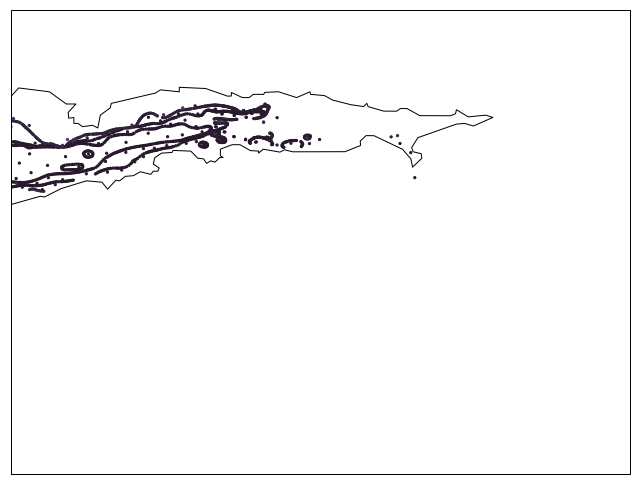

In [9]:
# set maximum depth for plotting
dmax = 10.

# coordinate limits
lonmin = -64.
lonmax = -63.2
latmin = 44.9
latmax = 45.5

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig = plt.figure(figsize=(9, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())

# colormap
cmap = cm.deep
cmap.set_bad('white')

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

ax.scatter(LLWLTMSL['lon'], LLWLTMSL['lat'],
           c=-LLWLTMSL['depth'],
           s=5,
           vmin=0.,
           vmax=dmax,
           cmap=cmap,
           transform=ccrs.PlateCarree())
ax.add_feature(coastline, linewidth=1.)

fig.tight_layout()

# file name of cleaned and corrected insitu data
#figname = os.path.join('/home/chrenkl/Projects/nemo_bathymetry/reports/figures/gridded_observations.pdf')

# save figure
#fig.savefig(figname)

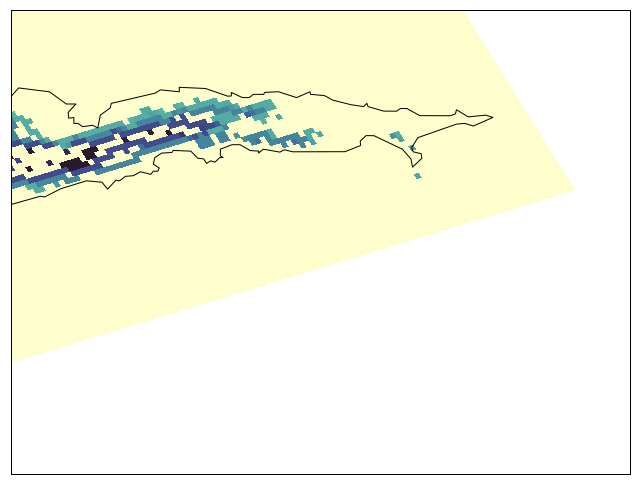

In [13]:
# set maximum depth for plotting
dmax = 25.

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig = plt.figure(figsize=(9, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())

# colormap
cmap = cm.deep
cmap.set_bad('white')

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

ax.pcolormesh(gridInSitu['lon'], gridInSitu['lat'],
              gridInSitu['depth'],
              vmin=0.,
              vmax=dmax,
              cmap=cmap,
              transform=ccrs.PlateCarree())
ax.add_feature(coastline, linewidth=1.)

fig.tight_layout()

# file name of cleaned and corrected insitu data
#figname = os.path.join('/home/chrenkl/Projects/nemo_bathymetry/reports/figures/gridded_observations.pdf')

# save figure
#fig.savefig(figname)